In [1]:
import math
import pandas as pd
from langdetect import detect
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer
import math
import matplotlib.pyplot as plt

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shirinharandi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
lem = WordNetLemmatizer() #create lemmatizer

In [3]:
dictionary = pd.read_csv('../data/processedDict.csv')
dictionary['word'].apply(lambda x: lem.lemmatize(x, pos='n'))

0         information
1      recommendation
2                 tip
3              advice
4          suggestion
            ...      
347           talking
348          chatting
349            moment
350              chat
351              talk
Name: word, Length: 352, dtype: object

In [4]:
filepath = '../data/en_reviews/Manchester.csv'
reviews = pd.read_csv(filepath)

# reviews = reviews['date']
reviews

table = str.maketrans('', '', string.punctuation) #mapping to strip punctuation in review

#strip punct of each review -> lemmatise -> output is list of words so join into sentences
reviews['comments'] = reviews.comments.apply(lambda review: ' '.join(map(str, [lem.lemmatize(word.translate(table), pos='n') for word in review.lower().split()])))
reviews

reviews['date'] = pd.to_datetime(reviews['date'])

In [5]:
#### DELETE THIS LATER ###
mask = (reviews['date'] >= '2014-01-01') & (reviews['date'] < '2018-01-01')
# mask = (reviews['date'] >= '2014-01-01') & (reviews['date'] < '2017-01-01')
reviews = reviews.loc[mask].copy()
reviews

reviews.describe()

,Unnamed: 0,listing_id,id,reviewer_id
count,34573.000000,3.457300e+04,3.457300e+04,3.457300e+04
mean,35114.694559,1.049706e+07,1.346352e+08,5.977622e+07
std,22863.367389,6.036341e+06,5.923397e+07,4.400382e+07
min,14.000000,6.895100e+04,9.515059e+06,1.667000e+03
25%,15499.000000,5.216954e+06,8.738570e+07,2.258146e+07
50%,33012.000000,1.122478e+07,1.399675e+08,4.885147e+07
75%,52335.000000,1.550818e+07,1.884633e+08,9.349942e+07
max,93328.000000,2.299882e+07,2.230249e+08,1.644092e+08


In [6]:
def get_trends(category, subcats):
    years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
    allwords = reviews['comments'].tolist()
    allwords = " ".join(allwords)
    unique_words = set(allwords.split(' '))
    len(unique_words)

    unique_words = list(unique_words)
    unique_words = [string for string in unique_words if string != ""]
    len(unique_words)

    unique_words[2]

    ls = []
    for word in unique_words:
        word = ''.join([i for i in word if not i.isdigit()])
        ls += [word]
    # result = ''.join([i for i in s if not i.isdigit()])
    unique_words= ls
    unique_words = [string for string in unique_words if string != ""]
    len(unique_words)

    def countWords(word, review):
        count = 0
        for i in review:
            if i == word:
                count+=1
        return count

    def getDenom(review, unique_words):
        count = 0
        den = 0
        ls = []
        review = review.split()
        for word in review:
            kmp = countWords(word, review)
            if (kmp > 0 and word not in ls):
                ls += [word]
                den += math.log(1 + kmp)
        return den

    reviews['den'] = reviews['comments'].apply(lambda x: getDenom(x, unique_words))

    def getNom(category, review, dictionary, cat_levl="cat_lev1"):
        nom = 0
        review = review.split()
        dictionaryWords = dictionary[(dictionary[cat_levl] == category)]
        dictionaryWords = dictionaryWords['word']
        for word in dictionaryWords:
            nom += math.log(1 + review.count(word))
        return nom

    temp = reviews['comments'].apply(lambda x: getNom(category, x, dictionary))
    reviews[category] = temp*100/reviews['den']
    k_total = reviews[category].loc[reviews[category] > 0].min()
    print(k_total)

    k = {}
    for subcat in subcats:
        temp = reviews['comments'].apply(lambda x: getNom(subcat, x, dictionary, cat_levl="cat_lev3"))
        reviews[subcat] = temp * 100 / reviews["den"]
        k[subcat] = reviews[subcat].loc[reviews[subcat] > 0].min()
    print(k)
    
    

    def adoptionForSetOfReviews(category, setOfReviews, dictionary, startDate, endDate, k):
        adoption = 1
        mask = (setOfReviews['date'] >= startDate) & (setOfReviews['date'] < endDate)
        setOfReviews = setOfReviews.loc[mask]
        setOfReviews = setOfReviews[category]
        if (len(setOfReviews) == 0):
            return 0
        else:
            b = 1/len(setOfReviews)
            for review in setOfReviews:
                adoption *= math.pow((review + k),b)
            adoption = adoption - k
            return adoption

    d2 = {'Year' : years, 'value':0.0}
    out = pd.DataFrame(data=d2)
    
    for i in range(len(years)):
        out.at[i, "value_{}_total".format(category)] = adoptionForSetOfReviews(category, reviews, dictionary, "{}-01-01".format(years[i]), "{}-01-01".format(years[i] + 1), k_total)
        for subcat in subcats:
            out.at[i, "value_{}_{}".format(category, subcat)] = adoptionForSetOfReviews(subcat, reviews, dictionary, "{}-01-01".format(years[i]), "{}-01-01".format(years[i] + 1), k[subcat])
    return out

In [7]:
def create_pivot(out_df, category, subcats):
    a = pd.DataFrame(columns=["year", "subcat", "val"])

    for subcat in subcats:
        ap = {"year": out_df["Year"], "val": out_df["value_{}_{}".format(category, subcat)]}
        ap = pd.DataFrame(data=ap)
        ap["subcat"] = subcat
        a = a.append(ap)
        
    pivot = a.pivot(index='year', columns='subcat', values='val')

    return pivot

In [8]:
# social_subcats = ["meal", "people", "personality_host", "talking", "sharing"]
# social = get_trends("social", social_subcats)

# pivot_social = create_pivot(social, "social", social_subcats)

# ax = pivot_social.loc[:,['meal','people', 'personality_host', 'sharing', 'talking']].plot.bar(stacked=True, figsize=(10,7), color=['#351800','#D85907','#D88A07','#FFA900','#FFD70F'])
# plt.title("Manchester")
# ax.get_legend().remove()

In [9]:
business_subcats = ['location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities', 'interiors']
business = get_trends("business", business_subcats)

1.221752695766037
{'location': 0.5029531073766607, 'communication': 0.31059423255865254, 'personality_host': 0.3093866502005734, 'property_type': 0.35417438269375745, 'logistic': 0.31059423255865254, 'advice': 0.30528239690480763, 'facilities': 0.3026747346414423, 'interiors': 0.36420561789903516}


In [10]:
business

,Year,value,value_business_total,value_business_location,value_business_communication,value_business_personality_host,value_business_property_type,value_business_logistic,value_business_advice,value_business_facilities,value_business_interiors
0,2010,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2011,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2012,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2013,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2014,0.0,13.827202,3.479113,0.089599,0.425489,1.205227,0.207485,0.044636,0.051847,2.065012
5,2015,0.0,13.894210,3.192743,0.101128,0.377746,1.255719,0.221188,0.050511,0.045935,2.076601
6,2016,0.0,13.896034,3.153361,0.125012,0.303874,1.115310,0.204471,0.036037,0.042131,1.945436
7,2017,0.0,13.433408,3.360050,0.147086,0.235901,0.845831,0.150143,0.022897,0.039029,1.718190
8,2018,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,2019,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<BarContainer object of 10 artists>

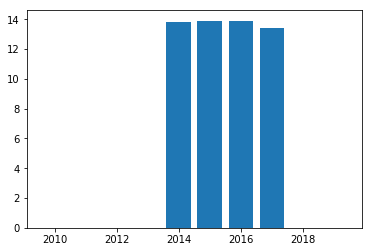

In [11]:
plt.bar(business["Year"], business["value_business_total"])

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


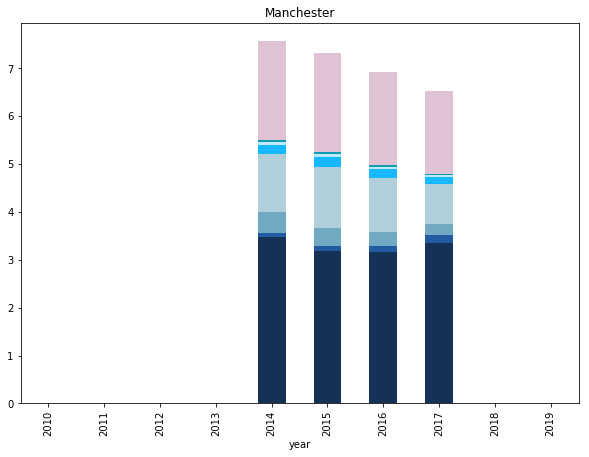

In [12]:
pivot_business = create_pivot(business, "business", business_subcats)
ax = pivot_business.loc[:,['location', 'communication', 'personality_host', 'property_type', 'logistic', 'advice', 'facilities', 'interiors']].plot.bar(stacked=True, figsize=(10,7), color=['#143258','#235BA0','#70A9C1','#B1CEDB','#16B9FF','#BCEBFF','#119DAF', '#DFC3D4'])
plt.title("Manchester")
ax.get_legend().remove()

In [13]:
soci[["Year", "value_social_meal"]]

NameError: name 'soci' is not defined

In [ ]:
p = {}
# "value_{}_{}".format(category, subcat)
for i in range(len(subcats)):
    p[subcats[i]] = plt.bar(soci["Year"], soci["value_{}_{}".format("social", subcats[i])])
plt.show()

In [ ]:
subcats = ["advice", "personality_host2", "logistic", "location", 
           "property_type", "facilities", "interiors", "communication"]
busi = get_trends_sad("business", subcats)